In [59]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',30)

#获取数据
data = pd.read_csv("ad_performance.csv",index_col=0)

# 对数据审查,是否有缺失值
print('{:*^60}'.format('数据样本：统计描述'))
print(data.describe().round(4).T)

# 对缺失值的填充(均值)
print('{:*^60}'.format('缺失值：均值填充法'))
# print(data[data.isna().values])
data = data.fillna(419.77)

*************************数据样本：统计描述**************************
        count      mean        std   min       25%       50%       75%  \
日均UV    889.0  540.8468  1634.4105  0.06    6.1800  114.1800  466.8700   
平均注册率   889.0    0.0014     0.0033  0.00    0.0000    0.0000    0.0014   
平均搜索量   889.0    0.0305     0.1062  0.00    0.0006    0.0032    0.0118   
访问深度    889.0    2.1672     3.8005  1.00    1.3923    1.7931    2.2162   
平均停留时间  887.0  262.6692   224.3649  1.64  126.0200  236.5500  357.9850   
订单转化率   889.0    0.0029     0.0116  0.00    0.0000    0.0002    0.0020   
投放总时间   889.0   16.0529     8.5094  1.00    9.0000   16.0000   24.0000   

               max  
日均UV    25294.7700  
平均注册率       0.0391  
平均搜索量       1.0370  
访问深度       98.9799  
平均停留时间   4450.8300  
订单转化率       0.2165  
投放总时间      30.0000  
*************************缺失值：均值填充法**************************


In [60]:
# 计算，合并:相关性
print('{:*^60}'.format('计算相关性：合并'))
print(data.corr().round(4).T)
data = data.drop(['平均停留时间'], axis=1)

**************************计算相关性：合并**************************
          日均UV   平均注册率   平均搜索量    访问深度  平均停留时间   订单转化率   投放总时间
日均UV    1.0000 -0.0512 -0.0735 -0.0217  0.0345 -0.0452 -0.0385
平均注册率  -0.0512  1.0000  0.2381  0.1063  0.2195  0.3166 -0.0141
平均搜索量  -0.0735  0.2381  1.0000  0.0631  0.1645  0.1259 -0.0268
访问深度   -0.0217  0.1063  0.0631  1.0000  0.7237  0.1637  0.0575
平均停留时间  0.0345  0.2195  0.1645  0.7237  1.0000  0.2525  0.0483
订单转化率  -0.0452  0.3166  0.1259  0.1637  0.2525  1.0000 -0.0046
投放总时间  -0.0385 -0.0141 -0.0268  0.0575  0.0483 -0.0046  1.0000


C:\Users\吕强\AppData\Local\Temp\ipykernel_17456\3066185843.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr().round(4).T)


In [61]:
# 数据标准化：归一化Min-Max，0-1区间
# SKLEAN-preprocessing-minmax
from sklearn.preprocessing import MinMaxScaler
matrix = data.iloc[:,1:7]
min_max_model = MinMaxScaler()
data_rescaled = min_max_model.fit_transform(matrix)
print(data_rescaled.round(2))


[[0.   0.18 0.02 0.01 0.12 0.66]
 [0.01 0.1  0.03 0.01 0.01 0.62]
 [0.   0.06 0.05 0.01 0.01 0.1 ]
 ...
 [0.01 0.01 0.   0.   0.   0.72]
 [0.05 0.   0.   0.   0.   0.31]
 [0.   0.   0.   0.53 0.   0.62]]


In [62]:
# 特征数字化：独热编码（One-Hot）
from sklearn.preprocessing import OneHotEncoder
print(data.iloc[:, 7:12].head(2))
onehot_mode = OneHotEncoder(sparse=False)
data_one = onehot_mode.fit_transform(data.iloc[:,7:12])
print('{:*^60}'.format('特征数字化：独热编码'))
print(data_one)

  素材类型    广告类型 合作方式    广告尺寸 广告卖点
0  jpg  banner  roi  140*40   打折
1  jpg  banner  cpc  140*40   满减
*************************特征数字化：独热编码*************************
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


d:\anaconda\envs\dd\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
#数据合并
print('{:*^60}'.format('数据维度合并：12个字段'))
data_matrix = np.hstack((data_rescaled, data_one))

************************数据维度合并：12个字段************************


In [64]:
# KMeans建模：基于平均轮廓系数，找到最佳K值(2-10)
# 关于K的取值范围：rfm用户价值(8),2-5
from sklearn.cluster import KMeans  #聚类算法
from sklearn.metrics import silhouette_score  # 用于评估度量的模块
print('{:*^60}'.format('KMeans建模：基于平均轮廓系数'))
score_list = []
max_score = -1
for k in range(2,6):# 2，3，4，5
    kmeans_model = KMeans(n_clusters=k) #建模
    kmeans_temp = kmeans_model.fit_predict(data_matrix) # 获取标签
    # print(kmeans_temp)
    score = silhouette_score(data_matrix,kmeans_temp)     # 得到每个K下的平均轮廓系数
    # print(k,score)
    # 获取最佳K值
    if score > max_score: # 如果平均轮廓系数更高
        max_score = score # 保存更高的系数值
        best_k = k        # 保存最佳的k值
        labels_temp = kmeans_temp  # 保存标签数据
    score_list.append([k, score])
print('{:*^60}'.format('所有的k值以及对应平均轮廓系数'))
print(score_list)
print('最佳K值：', best_k)

*********************KMeans建模：基于平均轮廓系数**********************


d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than av

**********************所有的k值以及对应平均轮廓系数***********************
[[2, 0.3865549293769709], [3, 0.4575788262257562], [4, 0.5020981194788053], [5, 0.48003589664576785]]
最佳K值： 4


d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\envs\dd\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [65]:
# 聚类结果分析
print('{:*^60}'.format('聚类结果分析'))
# 1.合并数据与聚类标签
cluster_labels = pd.DataFrame(labels_temp,columns=['clusters'])  # 将聚类标签转化为df
merge_data = pd.concat((data,cluster_labels),axis=1)   # 整合原始数据与聚类标签,纵向合并

***************************聚类结果分析***************************


In [66]:
# 2.各聚类下的样本量：select count(渠道标识） from table group by 聚类标签
cluster_counts = pd.DataFrame(merge_data['渠道代号'].groupby(merge_data['clusters'])
                              .count()).T.rename({'渠道代号':'counts'})             

In [67]:
# 3.各聚类下的样本占比
cluster_percents = (cluster_counts / len(data)).round(3).rename({'counts': 'percentage'})

In [68]:
# 4.数值类特征的均值
features = []
for label in range(best_k):
    label_data = merge_data[merge_data['clusters'] == label]
    # 4.数值类特征的均值
    p1_data = label_data.iloc[:,1:7] # 筛选出数值类特征
    p1_des = p1_data.describe().round(3)  # 获取描述性统计信息
    p1_mean = p1_des.iloc[1,:]  # 获取均值数据

    # 5.字符类特征的众数
    p2_data = label_data.iloc[:,7:12]  # 筛选出字符类特征
    p2_des = p2_data.describe()        # 获取描述性统计信息
    p2_mode = p2_des.iloc[2,:]         # 获取频数最高的标签

    # 横向拼接2类不同特征的数据
    merge_line = pd.concat((p1_mean,p2_mode),axis=0)
    # 纵向拼接4类簇的统计数据
    features.append(merge_line)
 

In [69]:
# 6.数据合并与展示
cluster_pd = pd.DataFrame(features).T
print('{:*^60}'.format('聚类结果分析：所有信息合并'))
all_cluster_pd = pd.concat((cluster_counts, cluster_percents, cluster_pd), axis=0)
print(all_cluster_pd)

***********************聚类结果分析：所有信息合并************************
                  0        1        2         3
counts          349      313      154        73
percentage    0.393    0.352    0.173     0.082
日均UV        300.205  572.521  613.836  1401.525
平均注册率         0.001    0.001    0.003     0.001
平均搜索量         0.016    0.051     0.02     0.033
访问深度           2.27    2.145     2.19     1.727
订单转化率         0.002    0.004    0.003     0.002
投放总时间         15.35   17.125   15.682    15.603
素材类型            jpg      swf      jpg       swf
广告类型             横幅      不确定   banner      tips
合作方式            cpc      roi      cpc       cpm
广告尺寸         600*90   600*90  308*388   450*300
广告卖点             直降       打折       满减        打折


In [70]:
# 数值特征的对比分析：绘制雷达图
# 1.获取各簇/类/集群的数值特征均值、并且标准化（Max-Min归一化，0~1）
print('{:*^60}'.format('数值特征的对比分析：绘制雷达图'))
nums_data = cluster_pd.iloc[:6,:].T.astype(np.float64)  # 获取数据并转为浮点数
nums_min_max = min_max_model.fit_transform(nums_data) # 获取标准化（归一化）后的数据
print(nums_min_max.round(4))

**********************数值特征的对比分析：绘制雷达图***********************
[[0.     0.     0.     1.     0.     0.    ]
 [0.2473 0.     1.     0.7698 1.     1.    ]
 [0.2848 1.     0.1143 0.8527 0.5    0.187 ]
 [1.     0.     0.4857 0.     0.     0.1425]]


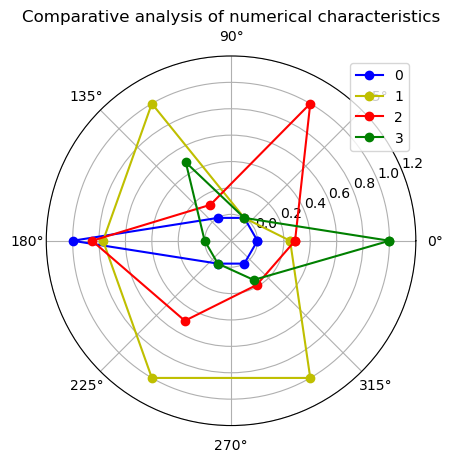

In [85]:
# 2.绘制画布、准备数据：x轴角度、y轴数据、类别对应颜色
import matplotlib.pyplot as plt
fig = plt.figure()  # 创建一个画布
ax = fig.add_subplot(111, polar=True)  # 创建子网格：正中央、极坐标系
angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)  # 计算角度
angles = np.concatenate((angles, [angles[0]]))  # 完成了对于x轴的设置,并且最后一个值=第一个值，以闭合图形
colors = ['b', 'y', 'r', 'g']
labels = p1_data.columns.tolist()
# 3.绘制各簇对应的点线图
# y轴的设置：0 1 2 3
for i in range(len(nums_min_max)):
    temp_list = nums_min_max[i]  # 获得对应簇数值特征数据
    temp = np.concatenate((temp_list, [temp_list[0]]))  # 完成闭合
    ax.plot(angles, temp, 'o-', color=colors[i], label=i)
ax.set_rlim(-0.2, 1.2)  # 设置半径刻度
plt.title("Comparative analysis of numerical characteristics")  # 设置标题
plt.legend()  # 类说明标签
plt.show()
